# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

In [2]:
import yfinance as yahooFinance

In [3]:
from pandasql import sqldf

# Load Data

In [4]:
AAPL = yahooFinance.Ticker("AAPL")
df =  pd.DataFrame(AAPL.history(period="3y"))

In [5]:
q = """
WITH raw AS (
    SELECT
        date,
        close,
        LAG(close, 1) OVER (ORDER BY date) AS min_1_close,
        LAG(close, 2) OVER (ORDER BY date) AS min_2_close,
        LAG(close, 3) OVER (ORDER BY date) AS min_3_close,
        LAG(close, 4) OVER (ORDER BY date) AS min_4_close
    FROM
        df
),
raw_plus_trend AS (
    SELECT
        date,
        close,
        min_1_close,
        CASE WHEN min_1_close - min_2_close > 0 THEN 1 ELSE -1 END AS min_1_trend,
        CASE WHEN min_2_close - min_3_close > 0 THEN 1 ELSE -1 END AS min_2_trend,
        CASE WHEN min_3_close - min_4_close > 0 THEN 1 ELSE -1 END AS min_3_trend
    FROM
        raw
),
train_data AS (
    SELECT
        date,
        close,
        min_1_close AS day_prev_close,
        CASE WHEN min_1_trend + min_2_trend + min_3_trend > 0 THEN 1 ELSE -1 END AS trend_3_day
    FROM
        raw_plus_trend
    ORDER BY
        date ASC
)
SELECT
    *
FROM
    train_data
"""
df = sqldf(q,globals())

In [6]:
print(type(df))
df.dropna(inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,close,day_prev_close,trend_3_day
1,2020-09-30 00:00:00.000000,113.753845,112.064392,-1
2,2020-10-01 00:00:00.000000,114.716454,113.753845,-1
3,2020-10-02 00:00:00.000000,111.013374,114.716454,1
4,2020-10-05 00:00:00.000000,114.431602,111.013374,1
5,2020-10-06 00:00:00.000000,111.150902,114.431602,1


In [7]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

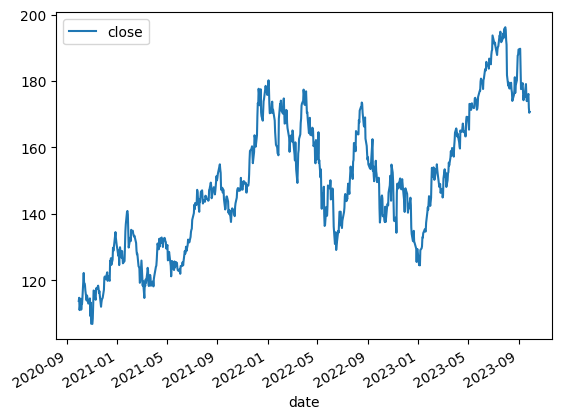

In [8]:
df.plot(x='date', y='close')

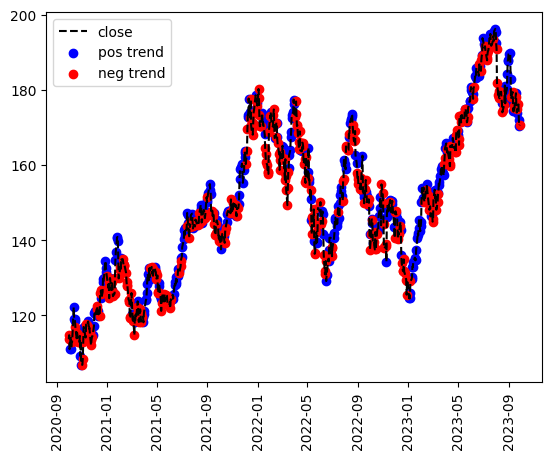

In [9]:
start_date = df['date'].min()
end_date = df['date'].max()

plt.plot(
    'date', 'close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_3_day == 1 & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_3_day == -1) & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [10]:
df.shape

(754, 4)

In [11]:
train = df[:527]
test = df[527:]

In [12]:
train.to_csv('train_AAPL.csv',index=False)
test.to_csv('test_AAPL.csv',index=False)

# Model Development

In [13]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2.12.0


In [14]:
CSV_COLUMNS = ['date', 'close', 'day_prev_close', 'trend_3_day']
LABEL_COLUMN = "close"
UNWANTED_COLS = ['date']

In [15]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS)

    dataset = dataset.map(features_and_labels)

    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Keras Sequential API

### Basic Neural Network

In [93]:
INPUT_COLS = ['day_prev_close', 'trend_3_day']

In [94]:
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

In [95]:
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(units=32, activation="relu", name="h1"),
    Dense(units=8, activation="relu", name="h2"),
    Dense(units=1, activation="linear", name="output")
    ])

In [96]:
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [97]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='train_AAPL.csv',
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = create_dataset(
    pattern='test_AAPL.csv',
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

In [98]:
%time 
# TODO 3
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./trading_trained_AAPL"
history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 19498.4570 - rmse: 139.6369 - mse: 19498.4570 - val_loss: 24766.7207 - val_rmse: 157.3744 - val_mse: 24766.7207
Epoch 2/50
1/1 [==============================] - 0s 223ms/step - loss: 18985.8379 - rmse: 137.7891 - mse: 18985.8379 - val_loss: 24264.8457 - val_rmse: 155.7716 - val_mse: 24264.8457
Epoch 3/50
1/1 [==============================] - 0s 195ms/step - loss: 18743.2598 - rmse: 136.9060 - mse: 18743.2598 - val_loss: 23771.4805 - val_rmse: 154.1800 - val_mse: 23771.4805
Epoch 4/50
1/1 [==============================] - 0s 214ms/step - loss: 18383.6230 - rmse: 135.5862 - mse: 18383.6230 - val_loss: 23277.0723 - val_rmse: 152.5681 - val_mse: 23277.0723
Epoch 5/50
1/1 [==============================] - 0s 212ms/step - loss: 17991.3125 - rmse: 134.1317 - mse: 17991.3125 - val_loss: 22793.2129 - val_rmse: 150.9741 - val_mse: 22793.2129
Epoch 6/50
1/1 [============================

1/1 [==============================] - 0s 277ms/step - loss: 7436.0449 - rmse: 86.2325 - mse: 7436.0449 - val_loss: 9314.4980 - val_rmse: 96.5116 - val_mse: 9314.4980
Epoch 40/50
1/1 [==============================] - 0s 226ms/step - loss: 7196.2861 - rmse: 84.8309 - mse: 7196.2861 - val_loss: 9015.5732 - val_rmse: 94.9503 - val_mse: 9015.5732
Epoch 41/50
1/1 [==============================] - 0s 224ms/step - loss: 6934.7441 - rmse: 83.2751 - mse: 6934.7441 - val_loss: 8725.4355 - val_rmse: 93.4100 - val_mse: 8725.4355
Epoch 42/50
1/1 [==============================] - 0s 206ms/step - loss: 6721.2930 - rmse: 81.9835 - mse: 6721.2930 - val_loss: 8457.7773 - val_rmse: 91.9662 - val_mse: 8457.7773
Epoch 43/50
1/1 [==============================] - 0s 209ms/step - loss: 6524.2949 - rmse: 80.7731 - mse: 6524.2949 - val_loss: 8196.3105 - val_rmse: 90.5334 - val_mse: 8196.3105
Epoch 44/50
1/1 [==============================] - 0s 242ms/step - loss: 6315.1572 - rmse: 79.4680 - mse: 6315.1572 -

In [99]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_3 (DenseFeat  multiple                 0         
 ures)                                                           
                                                                 
 h1 (Dense)                  multiple                  96        
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


<Axes: >

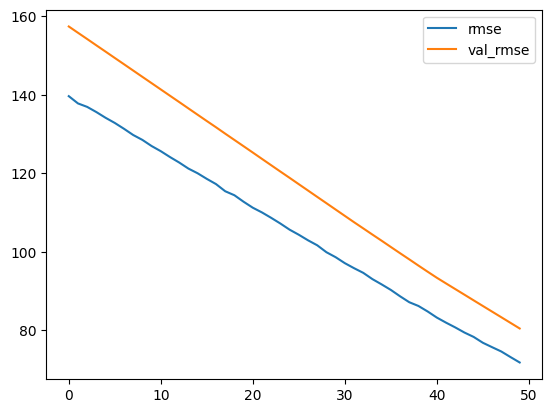

In [100]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

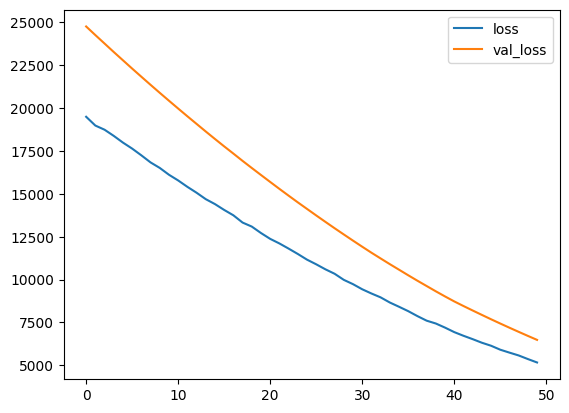

In [101]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

In [102]:
train = pd.read_csv('train_AAPL.csv')
test = pd.read_csv('test_AAPL.csv')

In [103]:
predict = model.predict(
    x={
        "trend_3_day": tf.convert_to_tensor(test['trend_3_day']),
        "day_prev_close": tf.convert_to_tensor(test['day_prev_close'])
    },
    steps=1,
)

1/1 [==============================] - 0s 49ms/step


In [104]:
train = pd.read_csv('train_AAPL.csv')
test = pd.read_csv('test_AAPL.csv')

In [105]:
test['predict'] = predict

In [106]:
df_pred = test[['date','close','predict']]

<Axes: >

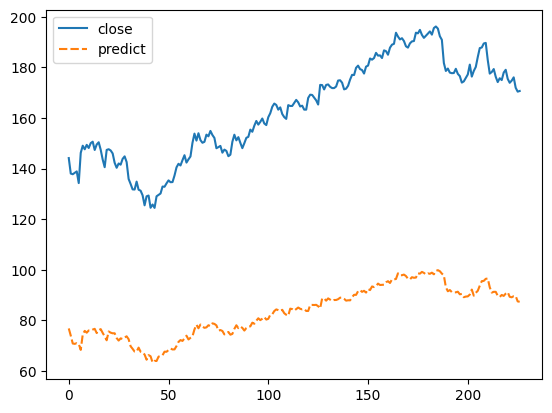

In [107]:
sns.lineplot(data=df_pred)

In [108]:
df_pred

,date,close,predict
0,2022-11-02,144.174698,76.849052
1,2022-11-03,138.060974,74.003983
2,2022-11-04,137.792114,70.890602
3,2022-11-07,138.329819,70.753685
4,2022-11-08,138.907349,71.027512
...,...,...,...
222,2023-09-22,174.789993,89.156693
223,2023-09-25,176.080002,89.594643
224,2023-09-26,171.960007,89.642815
225,2023-09-27,170.429993,87.544739


<Axes: xlabel='close', ylabel='predict'>

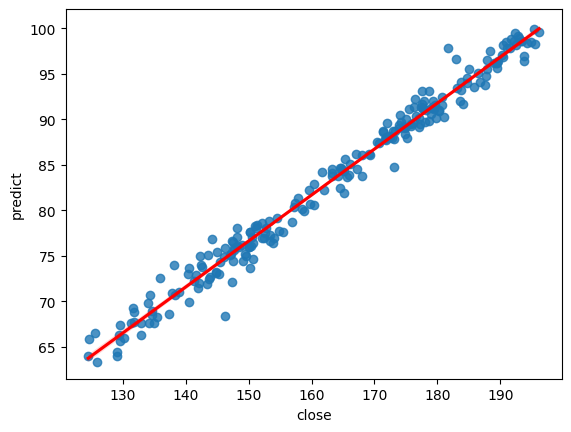

In [109]:
sns.regplot(x=df_pred['close'],y=df_pred['predict'],line_kws = {"color": "red"})

In [110]:
basic_neural_network = rmse(test['predict'],test['close']).numpy()

In [111]:
basic_neural_network

80.50383613256403

### Simple RNN and Bidirectional (RNN)

In [35]:
AAPL = yahooFinance.Ticker("AAPL")
df =  pd.DataFrame(AAPL.history(period="3y"))

In [48]:
df = df.reset_index()

In [49]:
df['Time'] = df['Date'].index.to_list()

In [54]:
class G:
    TIME, SERIES = df['Time'],df['Close']
    SPLIT_TIME = 527
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

In [55]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [71]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [56]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

In [57]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),
                              input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x:x*100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [58]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

16/16 [==============================] - 1s 7ms/step
Your current architecture is compatible with the windowed dataset! :)


In [59]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [60]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
16/16 [==============================] - 4s 11ms/step - loss: 64.7936 - mae: 65.2936 - lr: 1.0000e-06
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 20.0539 - mae: 20.5477 - lr: 1.1220e-06
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 14.6357 - mae: 15.1254 - lr: 1.2589e-06
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 14.2282 - mae: 14.7225 - lr: 1.4125e-06
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 14.0903 - mae: 14.5806 - lr: 1.5849e-06
Epoch 6/100
16/16 [==============================] - 0s 10ms/step - loss: 13.6980 - mae: 14.1852 - lr: 1.7783e-06
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 13.5409 - mae: 14.0303 - lr: 1.9953e-06
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 13.4112 - mae: 13.8989 - lr: 2.2387e-06
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 13.3455 - mae: 13.

Epoch 73/100
16/16 [==============================] - 0s 10ms/step - loss: 15.2553 - mae: 15.7486 - lr: 0.0040
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 23.6863 - mae: 24.1843 - lr: 0.0045
Epoch 75/100
16/16 [==============================] - 0s 9ms/step - loss: 19.9119 - mae: 20.4080 - lr: 0.0050
Epoch 76/100
16/16 [==============================] - 0s 10ms/step - loss: 19.9010 - mae: 20.3971 - lr: 0.0056
Epoch 77/100
16/16 [==============================] - 0s 9ms/step - loss: 27.9975 - mae: 28.4957 - lr: 0.0063
Epoch 78/100
16/16 [==============================] - 0s 10ms/step - loss: 35.0267 - mae: 35.5235 - lr: 0.0071
Epoch 79/100
16/16 [==============================] - 0s 10ms/step - loss: 38.4128 - mae: 38.9117 - lr: 0.0079
Epoch 80/100
16/16 [==============================] - 0s 10ms/step - loss: 20.3344 - mae: 20.8259 - lr: 0.0089
Epoch 81/100
16/16 [==============================] - 0s 9ms/step - loss: 44.6806 - mae: 45.1776 - lr: 0.0100
Epoch

(1e-06, 1.0, 0.0, 30.0)

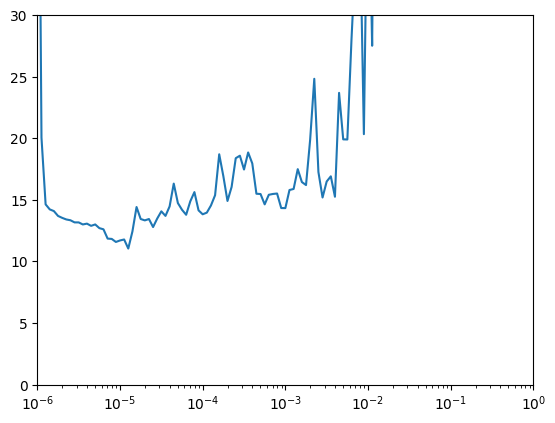

In [61]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [63]:
lr_history.history

{'loss': [64.79356384277344,
  20.053932189941406,
  14.635740280151367,
  14.228236198425293,
  14.090254783630371,
  13.697986602783203,
  13.540864944458008,
  13.411192893981934,
  13.345500946044922,
  13.173452377319336,
  13.171056747436523,
  13.005094528198242,
  13.071374893188477,
  12.892928123474121,
  13.006178855895996,
  12.707271575927734,
  12.610384941101074,
  11.857845306396484,
  11.830395698547363,
  11.584527969360352,
  11.705904960632324,
  11.785120010375977,
  11.049616813659668,
  12.433263778686523,
  14.42041301727295,
  13.44778060913086,
  13.335797309875488,
  13.445063591003418,
  12.795074462890625,
  13.484646797180176,
  14.070050239562988,
  13.699869155883789,
  14.471035957336426,
  16.321535110473633,
  14.74117374420166,
  14.196451187133789,
  13.791224479675293,
  14.88146686553955,
  15.63081169128418,
  14.149953842163086,
  13.830409049987793,
  13.964195251464844,
  14.544726371765137,
  15.376727104187012,
  18.70014190673828,
  16.9240

In [64]:
# Find the index of the minimum loss
min_loss_index = lr_history.history['loss'].index(min(lr_history.history['loss']))

# Get the corresponding learning rate
min_lr = lr_history.history['lr'][min_loss_index]

In [65]:
min_lr

1.2589254e-05

In [66]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1.2589254e-05, momentum=0.9),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [67]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
16/16 [==============================] - 4s 11ms/step - loss: 100.9656 - mae: 101.4655
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 24.3788 - mae: 24.8714
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 16.1263 - mae: 16.6181
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 14.1192 - mae: 14.6126
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 13.7909 - mae: 14.2843
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 13.9022 - mae: 14.3945
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 13.6054 - mae: 14.1005
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 13.1967 - mae: 13.6899
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 13.4890 - mae: 13.9832
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 13.5778 - mae: 14.0677
Epoch 11/50
16/16 [======================

In [68]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [69]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

23/23 [==============================] - 0s 4ms/step


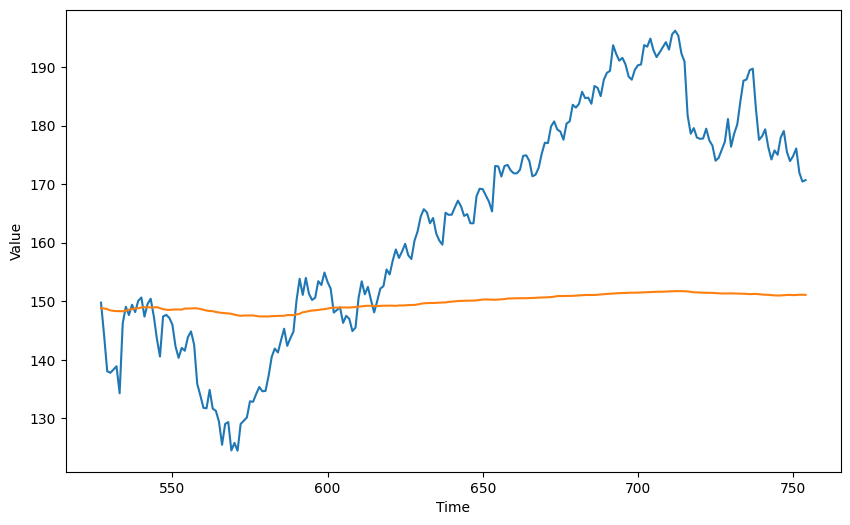

In [72]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [73]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 504.64, mae: 18.46 for forecast


### Batch Normalization

In [77]:
from tensorflow.keras.layers import BatchNormalization

In [78]:
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(units=64, activation="relu", name="h1"),
    BatchNormalization(),
    Dense(units=32, activation="relu", name="h2"),
    BatchNormalization(),
    Dense(units=16, activation="relu", name="h3"),
    Dense(units=1, activation="linear", name="output")
])

In [79]:
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [80]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='train_AAPL.csv',
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = create_dataset(
    pattern='test_AAPL.csv',
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

In [81]:
%time 
# TODO 3
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./trading_trained_AAPL"
history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 20698.7891 - rmse: 143.8707 - mse: 20698.7891 - val_loss: 22741.0703 - val_rmse: 150.8014 - val_mse: 22741.0703
Epoch 2/50
1/1 [==============================] - 0s 274ms/step - loss: 20745.1504 - rmse: 144.0318 - mse: 20745.1504 - val_loss: 22576.1484 - val_rmse: 150.2536 - val_mse: 22576.1484
Epoch 3/50
1/1 [==============================] - 0s 242ms/step - loss: 20735.2793 - rmse: 143.9975 - mse: 20735.2793 - val_loss: 22364.5801 - val_rmse: 149.5479 - val_mse: 22364.5801
Epoch 4/50
1/1 [==============================] - 0s 246ms/step - loss: 20678.2598 - rmse: 143.7994 - mse: 20678.2598 - val_loss: 22174.5840 - val_rmse: 148.9113 - val_mse: 22174.5840
Epoch 5/50
1/1 [==============================] - 0s 208ms/step - loss: 20669.4668 - rmse: 143.7688 - mse: 20669.4668 - val_loss: 22011.6211 - val_rmse: 148.3631 - val_mse: 22011.6211
Epoch 6/50
1/1 [==========================

1/1 [==============================] - 0s 232ms/step - loss: 19954.1152 - rmse: 141.2590 - mse: 19954.1152 - val_loss: 20094.1074 - val_rmse: 141.7536 - val_mse: 20094.1074
Epoch 40/50
1/1 [==============================] - 0s 223ms/step - loss: 20076.0703 - rmse: 141.6900 - mse: 20076.0703 - val_loss: 20040.3887 - val_rmse: 141.5641 - val_mse: 20040.3887
Epoch 41/50
1/1 [==============================] - 0s 213ms/step - loss: 19920.5469 - rmse: 141.1402 - mse: 19920.5469 - val_loss: 19994.7656 - val_rmse: 141.4028 - val_mse: 19994.7656
Epoch 42/50
1/1 [==============================] - 0s 230ms/step - loss: 19937.4688 - rmse: 141.2001 - mse: 19937.4688 - val_loss: 19947.9668 - val_rmse: 141.2371 - val_mse: 19947.9668
Epoch 43/50
1/1 [==============================] - 0s 208ms/step - loss: 19713.1113 - rmse: 140.4034 - mse: 19713.1113 - val_loss: 19900.5879 - val_rmse: 141.0694 - val_mse: 19900.5879
Epoch 44/50
1/1 [==============================] - 0s 200ms/step - loss: 19758.0508 - r

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 0         
 es)                                                             
                                                                 
 h1 (Dense)                  multiple                  96        
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


<Axes: >

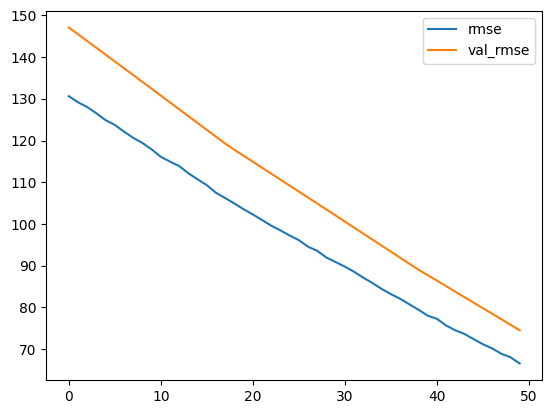

In [23]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

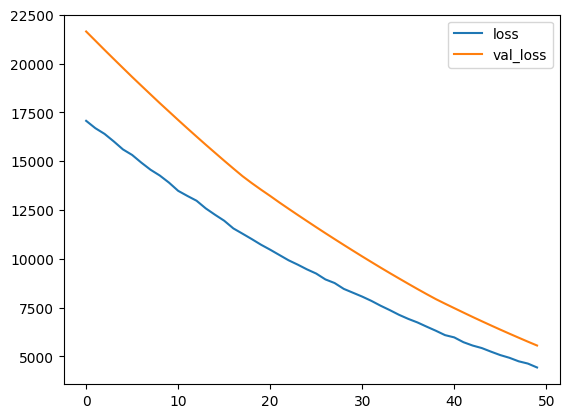

In [24]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

In [25]:
train = pd.read_csv('train_AAPL.csv')
test = pd.read_csv('test_AAPL.csv')

In [26]:
predict = model.predict(
    x={
        "trend_3_day": tf.convert_to_tensor(test['trend_3_day']),
        "day_prev_close": tf.convert_to_tensor(test['day_prev_close'])
    },
    steps=1,
)

1/1 [==============================] - 0s 75ms/step


In [27]:
train = pd.read_csv('train_AAPL.csv')
test = pd.read_csv('test_AAPL.csv')

In [85]:
test['predict'] = predict

In [86]:
df_pred = test[['date','close','predict']]

<Axes: >

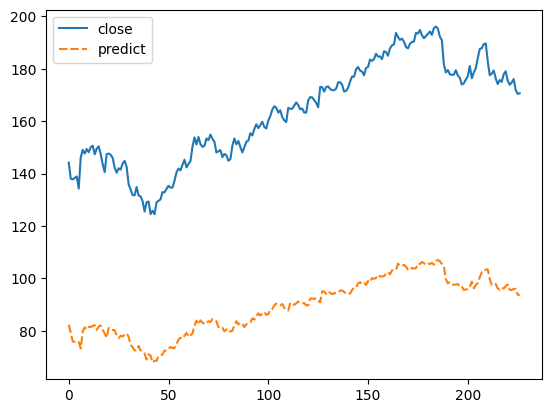

In [87]:
sns.lineplot(data=df_pred)

In [92]:
batch_normalization = rmse(test['predict'],test['close']).numpy()

### Dropout and Bidirectional RNN

In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

# Load your dataset, assuming you have a DataFrame df with columns 'day_prev_close' and 'trend_3_day'
# Replace this with your actual data loading process
# df = pd.read_csv('your_dataset.csv')

# Extract features and target
features = ['day_prev_close', 'trend_3_day']
target = 'close'  # Replace 'close' with your target column name

# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train[features],test[features],train[target],test[target]

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)

# Define the number of time steps for sequence data
time_steps = 10  # Adjust as needed

# Reshape the data into sequences
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequence = data[i:i + time_steps, :]
        sequences.append(sequence)
    return np.array(sequences)

X_train_seq = create_sequences(X_train, time_steps)
X_eval_seq = create_sequences(X_eval, time_steps)

# Define the model
model = Sequential([
    Bidirectional(LSTM(units=32, return_sequences=True, activation="relu"), name="bi_lstm"),
    Dense(units=64, activation="relu", name="h1"),
    Dropout(0.5),
    Dense(units=32, activation="relu", name="h2"),
    Dropout(0.5),
    Dense(units=16, activation="relu", name="h3"),
    Dense(units=1, activation="linear", name="output")
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=[RootMeanSquaredError(), "mse"])

# Define callbacks
LOGDIR = "./trading_logs"
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard = TensorBoard(LOGDIR)

# Train the model
history = model.fit(
    X_train_seq,
    y_train[time_steps:],  # Target values should be shifted accordingly
    validation_data=(X_eval_seq, y_eval[time_steps:]),  # Validation data
    epochs=50,  # Adjust as needed
    batch_size=64,  # Adjust as needed
    callbacks=[early_stopping, tensorboard]
)

# Evaluate the model
eval_loss, eval_rmse, eval_mse = model.evaluate(X_eval_seq, y_eval[time_steps:])
print(f"Evaluation Loss: {eval_loss}, RMSE: {eval_rmse}, MSE: {eval_mse}")

# Make predictions
predictions = model.predict(X_eval_seq)

Epoch 1/50
9/9 [==============================] - 3s 54ms/step - loss: 20994.2070 - root_mean_squared_error: 144.8938 - mse: 20994.2070 - val_loss: 27227.3594 - val_root_mean_squared_error: 165.0072 - val_mse: 27227.3594
Epoch 2/50
9/9 [==============================] - 0s 12ms/step - loss: 20912.8203 - root_mean_squared_error: 144.6127 - mse: 20912.8203 - val_loss: 27075.0820 - val_root_mean_squared_error: 164.5451 - val_mse: 27075.0820
Epoch 3/50
9/9 [==============================] - 0s 11ms/step - loss: 20759.8242 - root_mean_squared_error: 144.0827 - mse: 20759.8242 - val_loss: 26746.9824 - val_root_mean_squared_error: 163.5450 - val_mse: 26746.9824
Epoch 4/50
9/9 [==============================] - 0s 12ms/step - loss: 20413.7285 - root_mean_squared_error: 142.8766 - mse: 20413.7285 - val_loss: 25899.6680 - val_root_mean_squared_error: 160.9337 - val_mse: 25899.6680
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 19460.9102 - root_mean_squared_error: 139.502

Epoch 39/50
9/9 [==============================] - 0s 10ms/step - loss: 1303.7937 - root_mean_squared_error: 36.1081 - mse: 1303.7937 - val_loss: 132.7968 - val_root_mean_squared_error: 11.5237 - val_mse: 132.7968
Epoch 40/50
9/9 [==============================] - 0s 10ms/step - loss: 1296.5540 - root_mean_squared_error: 36.0077 - mse: 1296.5540 - val_loss: 135.7358 - val_root_mean_squared_error: 11.6506 - val_mse: 135.7358
Epoch 41/50
9/9 [==============================] - 0s 11ms/step - loss: 1279.0114 - root_mean_squared_error: 35.7633 - mse: 1279.0114 - val_loss: 141.7821 - val_root_mean_squared_error: 11.9072 - val_mse: 141.7821
Epoch 42/50
9/9 [==============================] - 0s 10ms/step - loss: 1310.1884 - root_mean_squared_error: 36.1965 - mse: 1310.1884 - val_loss: 115.6518 - val_root_mean_squared_error: 10.7542 - val_mse: 115.6518
Epoch 43/50
9/9 [==============================] - 0s 11ms/step - loss: 1249.2102 - root_mean_squared_error: 35.3442 - mse: 1249.2102 - val_loss

In [127]:
test['close'][time_steps:]

10     148.157883
11     150.079697
12     150.647263
13     147.381195
14     149.541977
          ...    
222    174.789993
223    176.080002
224    171.960007
225    170.429993
226    170.690002
Name: close, Length: 217, dtype: float64

In [140]:
predictions_list

[[[138.697265625],
  [133.63316345214844],
  [130.50253295898438],
  [129.49830627441406],
  [129.63670349121094],
  [133.63140869140625],
  [134.1744842529297],
  [135.56138610839844],
  [134.5491485595703],
  [131.19485473632812]],
 [[137.29139709472656],
  [132.76795959472656],
  [130.6578369140625],
  [129.96881103515625],
  [133.8329620361328],
  [134.67335510253906],
  [136.8172607421875],
  [136.94227600097656],
  [134.9238739013672],
  [131.4428253173828]],
 [[133.7007598876953],
  [130.39761352539062],
  [128.70721435546875],
  [132.1287841796875],
  [133.1571502685547],
  [135.70675659179688],
  [136.58897399902344],
  [135.75341796875],
  [133.5193328857422],
  [128.03428649902344]],
 [[134.95162963867188],
  [131.71250915527344],
  [134.36863708496094],
  [135.157958984375],
  [137.86219787597656],
  [139.19004821777344],
  [139.2062225341797],
  [138.22157287597656],
  [132.5824737548828],
  [132.83973693847656]],
 [[136.4466094970703],
  [137.93858337402344],
  [138.23497

In [129]:
predictions_list = predictions.tolist()

In [142]:
# Create a DataFrame to combine evaluation data and predictions
eval_df = pd.DataFrame({
    'date': test['date'][time_steps:],  # Assuming 'date' is your date column
    'actual_close': test['close'][time_steps:],  # Actual close values from evaluation data
    'predicted_close': [pred[0][0] for pred in predictions],  # Predicted close values
})
batch_normalization = rmse(test['predict'],test['close']).numpy()

In [143]:
eval_df

,date,actual_close,predicted_close
10,2022-11-16,148.157883,138.697266
11,2022-11-17,150.079697,137.291397
12,2022-11-18,150.647263,133.700760
13,2022-11-21,147.381195,134.951630
14,2022-11-22,149.541977,136.446609
...,...,...,...
222,2023-09-22,174.789993,177.149231
223,2023-09-25,176.080002,174.102646
224,2023-09-26,171.960007,177.410995
225,2023-09-27,170.429993,178.834671


<Axes: >

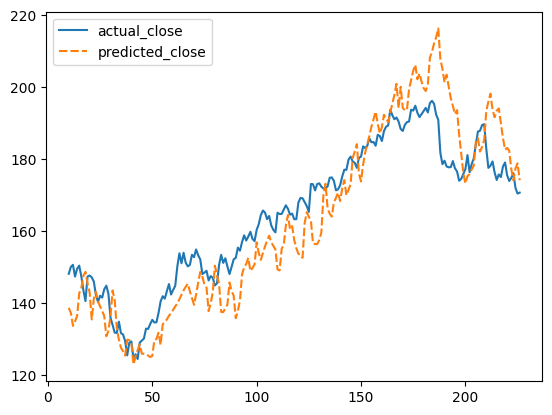

In [144]:
sns.lineplot(data=eval_df)

In [146]:
basic_bidirectional = rmse(eval_df['actual_close'],eval_df['predicted_close'])

In [148]:
basic_bidirectional.numpy()

9.734189574967694